## Load contig cluster and sample information

In [1]:
import os,json,glob
from collections import defaultdict, namedtuple
Member = namedtuple('Member', ['contig', 'length', 'percent_id', 'percent_id_sign', 'sample', 'coverage'])

import ete3
ncbi=ete3.ncbi_taxonomy.NCBITaxa()


base_path='/Users/evogytis/Documents/manuscripts/skeeters/data/s3/' ## where contig_quality and contig folders sit

metadata={}
for line in open(os.path.join(base_path,'../metadata/CMS001_CMS002_MergedAnnotations.csv'),'r'):
    l=line.strip('\r\n').split(',')
    if 'NewIDseqName' in l[0]:
        header=l
    else:
        metadata[l[0]]={header[i]:l[i].strip(' ') for i in range(len(l))} ## load metadata


def parse_cdhit_row(row):
    if '*' in row:
        index, length, name, percent_id = row.split()
        percent_id_sign, percent_id = '0', 100
    else:
        index, length, name, _, percent_id = row.split()
    length = int(length.strip(',nt'))
    name = name.strip('>').strip('.')
    sample, contig = name.split('~')
    coverage = float(contig.split('_')[-1])
    
    if percent_id != 100:
        percent_id_sign, percent_id = percent_id.strip('%').split('/')
        percent_id = float(percent_id)
    return Member(contig=contig, sample=sample, length=length,
                  percent_id=percent_id, percent_id_sign=percent_id_sign, coverage=coverage)


clusters = defaultdict(list)
with open(base_path+'../500_contigs_cluster.clstr', 'r') as file:
    for line in file:
        if line.startswith('>Cluster'):
            cluster_id = line.split()[-1]
        else:
            member = parse_cdhit_row(line)
            if 'water' in member.sample.lower():
                continue
            clusters[cluster_id].append(member) ## load clustered contig data
            
contig2cluster={}
for cluster_id in clusters:
    for m in clusters[cluster_id]:
        contig2cluster[m.contig]=cluster_id

In [2]:
# lca_decontam=0

# for line in open(os.path.join(base_path,'contig_quality_concat/lca_decontam.tsv'),'r'):
#     l=line.strip('\n').split('\t')
    
#     if l[0]=='sample':
#         header={x: i for i,x in enumerate(l)}
#     else:
#         taxid=int(l[header['taxid']])
#         sample=l[header['sample']]
#         reads=int(l[header['reads']])
#         lca_decontam+=reads
        
# print(lca_decontam)


# lca_contam=0

# for line in open(os.path.join(base_path,'contig_quality_concat/lca_contamination.tsv'),'r'):
#     l=line.strip('\n').split('\t')
    
#     if l[0]=='sample':
#         header={x: i for i,x in enumerate(l)}
#     else:
#         taxid=int(l[header['taxid']])
#         sample=l[header['sample']]
#         reads=int(l[header['reads']])
#         lca_contam+=reads
        
# print(lca_contam)


# vir_decontam=0

# for line in open(os.path.join(base_path,'contig_quality_concat/viral_decontam.tsv'),'r'):
#     l=line.strip('\n').split('\t')
    
#     if l[0]=='sample':
#         header={x: i for i,x in enumerate(l)}
#     else:
# #         taxid=int(l[header['taxid']])
#         sample=l[header['sample']]
#         reads=int(l[header['reads']])
#         vir_decontam+=reads
        
# print(vir_decontam)

## Load read counts, contig LCA, and contamination information

In [3]:
nonhost_reads={}
total_reads={}
for line in open(base_path+'../metadata/idseq_metadata.csv','r'):
    l=line.strip('\n').split(',')
    if l[0]=='sample':
        header={x:i for i,x in enumerate(l)}
    else:
        sample=l[header['sample']]
        nonhost=int(l[header['nonhost_reads']]) ## get nonhost reads
        total=int(l[header['total_reads']])
        
        if sample not in total_reads: ## sample not seen before
            total_reads[sample]=0
        if sample not in nonhost_reads:
            nonhost_reads[sample]=0
            
        total_reads[sample]+=total ## sum non-host reads for sample
        nonhost_reads[sample]+=nonhost
grand_total=sum(nonhost_reads.values()) ## sum all of sample nonhost reads


curated_viral={}
in_json=open(base_path+'../darkmatter/virus.json','r')
virus=json.load(in_json) ## open curated virus list

in_json.close()

for pol_group in virus: ## iterate over polymerase groups
    for seg in virus[pol_group]['segments']: ## iterate over segments of virus
        for clust in virus[pol_group]['segments'][seg]['clusters']: ## iterate over clusters that contain viral contigs
            for m in clusters[str(clust)]: ## iterate over contigs in cluster
                if m.sample not in curated_viral:
                    curated_viral[m.sample]=set()
                    
                curated_viral[m.sample].add(m.contig) ## contigs stored under sample
                

contig_classification={}

for fname in glob.glob(os.path.join(base_path,'contig_quality/*/contig_stats_all.tsv')): ## iterate over all contig stats
    fsample=os.path.basename(os.path.dirname(fname))
        
    for line in open(fname,'r'): ## iterate over all contigs
        l=line.strip('\n').split('\t')
        
        if l[0]=='sample':
            header={x:i for i,x in enumerate(l)}
        else:
            sample,contig,length,read_count=l
            
            if sample not in contig_classification:
                contig_classification[sample]={}
            
            length=int(length)
            read_count=int(read_count)
            
            if read_count>=2: ## at least 2 reads, non-hexapoda
                contig_classification[sample][contig]={'read_count': read_count}
                contig_classification[sample][contig]['blasts']=False ## assume blast is False
                contig_classification[sample][contig]['co-occurs']=False ## assume not discovered via co-occurrence
                if sample in curated_viral and contig in curated_viral[sample]: ## unless curated
                    contig_classification[sample][contig]['co-occurs']=True ## assume discovered via co-occurrence


hexapoda_reads={}
hexapoda_contigs={}

for fname in glob.glob(os.path.join(base_path,'contig_quality/*/contig_stats_lca.tsv')): ## iterate over blast results
    fsample=os.path.basename(os.path.dirname(fname))
    
    if fsample not in curated_viral:
        curated_viral[fsample]={}
        
    if fsample not in hexapoda_reads:
        hexapoda_reads[fsample]=0
        hexapoda_contigs[fsample]=set()
        
    for line in open(fname,'r'): ## iterate over contigs
        l=line.strip('\n').split('\t')
        
        if l[0]=='sample':
            header={x:i for i,x in enumerate(l)}
        else:
            sample=l[header['sample']] ## get sample
            assert sample==fsample
            
            contig=l[header['contig_name']] ## get contig name
            tax=l[header['taxon_group']] ## get taxonomic assignment
            read_count=int(l[header['read_count']])
            length=int(l[header['contig_length']])
            
            if read_count>=2: ## at least 2 reads
                if tax=='': ## hexapoda... or is it?
                    assert l[header['hexapoda']]=='True'
                    if sample in curated_viral and contig in curated_viral[sample]:
                        contig_classification[sample][contig]['tax_group']='Viral via co-occurrence'
                        contig_classification[sample][contig]['co-occurs']=True
                        contig_classification[sample][contig]['blasts']=False
                        
                    else:
                        contig_classification[sample].pop(contig) ## remove hexapoda contig
                        hexapoda_reads[sample]+=read_count
                        hexapoda_contigs[sample].add(contig) ## pretend contig never existed
                        
                else: ## not hexapoda, valid LCA
                    if sample in curated_viral and contig in curated_viral[sample] and tax!='Viruses': ## viral contig that wasn't called viral
                        contig_classification[sample][contig]['co-occurs']=True ## switch to discovery by co-occurence
                        contig_classification[sample][contig]['blasts']=False ## blast was wrong
                    else:
                        contig_classification[sample][contig]['blasts']=True ## clearly blasted
                        contig_classification[sample][contig]['co-occurs']=False ## can't be discovered via co-occurrence
                        contig_classification[sample][contig]['tax_group']=tax ## assign taxonomy
                    

nonviral_contamination={}
for line in open(os.path.join(base_path,'contig_quality_concat/lca_contamination.tsv'),'r'):
    l=line.strip('\n').split('\t')
    
    if l[0]=='sample':
        header={x: i for i,x in enumerate(l)}
    else:
        taxid=int(l[header['taxid']])
        sample=l[header['sample']]
        reads=int(l[header['reads']])
        
        if sample not in nonviral_contamination:
            nonviral_contamination[sample]={}
        try:
            lineage=ncbi.get_lineage(taxid)
            
            category=None
            
            if 10239 in lineage:
                category='Viruses'
            elif 2 in lineage:
                category='Bacteria'
            elif 33208 in lineage:
                category='Metazoa'
            elif 2759 in lineage:
                category='Eukaryota'
            elif 2157 in lineage:
                category='Archaea'
            else:
                category='Ambiguous'
                
            if category not in nonviral_contamination[sample]:
                nonviral_contamination[sample][category]=0

            nonviral_contamination[sample][category]+=reads
                
        except ValueError:
            print('taxid %s not available'%(taxid))


## Assign reads to treemap categories

In [4]:
import copy

template={'name': 'all reads', 'read_count': 0, 'colour': '#F8F5F5', 'children': [
                           {'name': 'unassembled', 'read_count': 0, 'colour': '#7F838A'}, 
                           {'name': 'contigs', 'read_count': 0, 'colour': '#BFABA6', 
                                   'children': [
                                       {'name': 'dark contigs', 'read_count': 0, 'colour': '#4E5459'}, 
                                       {'name': 'Archaea', 'read_count': 0, 'colour': '#976394'}, 
                                       {'name': 'Bacteria', 'read_count': 0, 'colour': '#5D5B7C'}, 
                                       {'name': 'Ambiguous', 'read_count': 0, 'colour': '#2A3A57'}, 
                                       {'name': 'Eukaryota', 'read_count': 0, 'colour': '#498BCA', 'children': [
                                           {'name': 'Metazoa', 'read_count': 0, 'colour': '#59C5DD'}
                                       ]}, 
                                       {'name': 'Viruses', 'read_count': 0, 'colour': '#C7464B', 'children': [
                                           {'name': 'Viral via co-occurrence', 'read_count': 0, 'colour': '#893143'}]}
                                   ]}
                      ]
         }


def getCategory(node,name,result=None):
    """
    Given a treemap dict and name of compartment returns compartment with matching name.
    """
    if 'children' in node:
        for child in node['children']:
            result=getCategory(child,name,result=result)
            
    if name==node['name']:
        result=node
    
    return result
    
    
total_unassembled=grand_total ## all reads across all samples
for sample in contig_classification: ## iterate over samples
    total_unassembled-=sum([contig_classification[sample][c]['read_count'] for c in contig_classification[sample]]) ## subtract reads in contigs
    total_unassembled-=hexapoda_reads[sample] ## subtract hexapoda reads

total_unassembled-=sum([sum(contam.values()) for contam in nonviral_contamination.values()]) ## remove contamination
    

one_tree=copy.deepcopy(template)
cat=getCategory(one_tree,'unassembled')
cat['read_count']+=total_unassembled

grand_tree={}
for sample in nonhost_reads: ## iterate over samples
    if sample not in grand_tree:
        grand_tree[sample]=copy.deepcopy(template) ## add empty template treemap to sample
        cat=getCategory(grand_tree[sample],'unassembled') ## assign unassembled reads
        
        if sample in contig_classification:
            nonhost_in_sample=nonhost_reads[sample]
            reads_in_contigs=sum([contig_classification[sample][c]['read_count'] for c in contig_classification[sample]])
            
            cat['read_count']+=(nonhost_in_sample-reads_in_contigs-hexapoda_reads[sample]) ## unassembled reads is nonhost reads minus all reads in contigs minus hexapoda reads
        

for sample in contig_classification: ## iterate over samples
    sample_tree=grand_tree[sample] ## get sample subtree
    
    for contig in contig_classification[sample]: ## iterate over contigs
        C=contig_classification[sample][contig] ## get classification for contig
        
        reads=C['read_count']
        if C['blasts']==True: ## contig blasted
            assert C['co-occurs']==False ## to be safe that contig didn't co-occur
            tax_group=C['tax_group'] ## grab assigned taxonomic group
            cat=getCategory(sample_tree,tax_group)
            CAT=getCategory(one_tree,tax_group)

        elif C['co-occurs']==True: ## blasts==False but co-occurs==True
            cat=getCategory(sample_tree,'Viral via co-occurrence')
            CAT=getCategory(one_tree,'Viral via co-occurrence')
        else: ## didn't blast, didn't co-occur and therefore dark
            cat=getCategory(sample_tree,'dark contigs')
            CAT=getCategory(one_tree,'dark contigs')
            pass

        cat['read_count']+=reads ## add reads to appropriate category of treemap
        CAT['read_count']+=reads

### decontam
for sample in nonviral_contamination:
    sample_tree=grand_tree[sample]
    for category in nonviral_contamination[sample]:
        cat=getCategory(sample_tree,category)
        cat['read_count']-=nonviral_contamination[sample][category]
        
# print(category) ## reports per-branch read counts (parents without read counts of their children yet)

def sumValues(node,stat):
    """
    Passes read counts from children to parents.
    """
    if 'children' in node:
        for child in node['children']:
            node[stat]+=sumValues(child,stat) ## traverse first (reaches tips first)
            
    return node[stat]

sumValues(one_tree,'read_count') ## add values of children to parents

def reportStats(node,level=None,collect={}):
    """
    Traverse treemap and report read counts across compartments.
    """
    if level==None:
        level=0
        note=''
    elif level==3:
        note='of which in'
    else:
        note='in'
    
#     print('%s|%d\t%s %s'%(level*'   ',node['read_count'],note,node['name']))
    collect[node['name']]=node['read_count']
    
    if 'children' in node:
        level+=1
        for child in sorted(node['children'],key=lambda w: -w['read_count']):
            reportStats(child,level,collect=collect)
    
    return collect

print('\n\n')
all_reads=reportStats(one_tree)
print('all reads: %s'%(all_reads))
column_order=['all reads', 'contigs', 'Viruses', 'Viral via co-occurrence', 'dark contigs', 'Eukaryota', 'Metazoa', 'Bacteria', 'Ambiguous', 'Archaea', 'unassembled']

out_read_stats=open('/Users/evogytis/Downloads/TableSX_read-breakdown.tsv','w')
out_read_stats.write('sample\t%s\n'%('\t'.join(column_order)))
out_read_stats.write('all\t%s\n'%('\t'.join(['%d'%(all_reads[key]) for key in column_order])))


for sample in grand_tree:
    print(sample)
    sample_tree=grand_tree[sample]
    sumValues(sample_tree,'read_count')
    reads=reportStats(sample_tree)
    print(reads)
    out_read_stats.write('%s\t%s\n'%(sample,'\t'.join(['%d'%(reads[key]) for key in column_order])))
#     out_read_stats.write('%s\t%s\n'%(sample,'\t'.join(map(str,[total_reads[sample],nonhost_reads[sample],getCategory(sample_tree,'contigs')['read_count']]))))
    
    
out_read_stats.close()




all reads: {'all reads': 21693128, 'contigs': 16588409, 'Viruses': 10925355, 'Viral via co-occurrence': 2226310, 'dark contigs': 3884366, 'Eukaryota': 766179, 'Metazoa': 190489, 'Bacteria': 594424, 'Ambiguous': 417672, 'Archaea': 413, 'unassembled': 5104719}
CMS001_001_Ra_S1
{'all reads': 642825, 'contigs': 551731, 'Viruses': 336091, 'Viral via co-occurrence': 11232, 'dark contigs': 48975, 'Eukaryota': 40621, 'Metazoa': 3395, 'Bacteria': 45962, 'Ambiguous': 80066, 'Archaea': 16, 'unassembled': 91094}
CMS001_002_Ra_S1
{'all reads': 357054, 'contigs': 326291, 'Viruses': 306101, 'Viral via co-occurrence': 7341, 'dark contigs': 16806, 'Eukaryota': 635, 'Metazoa': 529, 'Bacteria': 63, 'Ambiguous': 2568, 'Archaea': 118, 'unassembled': 30763}
CMS001_003_Ra_S2
{'all reads': 164488, 'contigs': 77480, 'Viruses': 4532, 'Viral via co-occurrence': 4228, 'dark contigs': 66807, 'Eukaryota': 5495, 'Metazoa': 4668, 'Bacteria': 406, 'Ambiguous': 240, 'Archaea': 0, 'unassembled': 87008}
CMS001_004_Ra_

## Plot per-sample read information as both relative and absolute bars

145


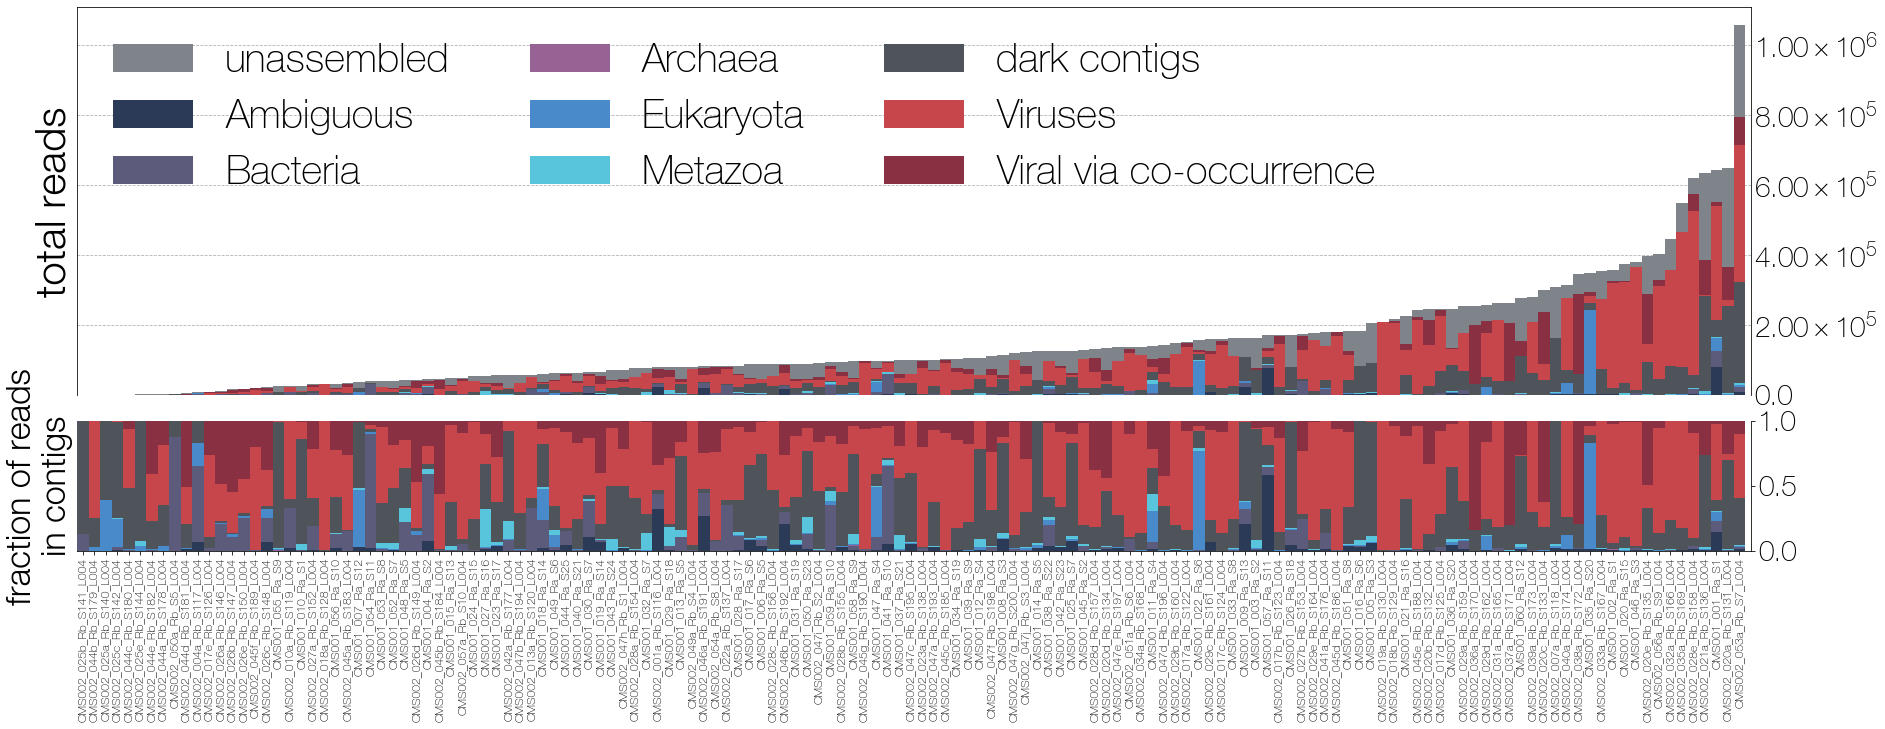

In [5]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects

import numpy as np
import squarify

typeface='Helvetica Neue'
mpl.rcParams['mathtext.fontset']='custom'
mpl.rcParams['font.sans-serif']=typeface
mpl.rcParams['mathtext.default']='sf'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

size=lambda k: k['read_count']

def extract_nested_reads(node,flat={},order=None):
    if order==None:
        order=0
        
    flat[node['name']]={'read_count': node['read_count'], 'colour': node['colour'], 'order': order}
    order+=1
    if 'children' in node:
        flat[node['name']]['children']=[]
        for child in sorted(node['children'],key=lambda k: -size(k)): ## iterate over children
            flat,order=extract_nested_reads(child,flat,order)
            
            flat[node['name']]['children'].append(child['name'])
    
    return flat,order

sorted_samples=sorted(grand_tree,key=lambda k: grand_tree[k]['read_count'])#[:10]

sample_reads=lambda k: sum([contig_classification[k][c]['read_count'] for c in contig_classification[k]]) if k in contig_classification else 0.0
sorted_samples=list(filter(lambda k: 'water' not in k.lower() and sample_reads(k)>0,sorted_samples))#[:5]

read_areas=[grand_tree[sample]['read_count'] for sample in sorted_samples]

species=lambda sample: '%s %s'%(metadata[sample]['ska_genus'],metadata[sample]['ska_species'])
sample_loc=lambda sample: metadata[sample]['collected_by']


fig = plt.figure(figsize=(30,10),facecolor='w') ## new figure
# fig = plt.figure(figsize=(10,10),facecolor='w') ## new figure

gs = gridspec.GridSpec(2,1,height_ratios=[3,1],wspace=0.05,hspace=0.1) ## using gridspec
print(len(sorted_samples))

ax=plt.subplot(gs[0],facecolor='w') ## new canvas
ax2=plt.subplot(gs[1],facecolor='w')

M=max(read_areas)

contig_categories=['Ambiguous','Bacteria','Archaea','Eukaryota','Metazoa','dark contigs','Viruses','Viral via co-occurrence']

for s,sample in enumerate(sorted_samples):
    sample=sorted_samples[s]
    sample_tree=grand_tree[sample]
    sample_total=grand_tree[sample]['read_count']

    xlabels=[]
    reads,_=extract_nested_reads(sample_tree)

    for g,group in enumerate(contig_categories):
        if 'children' in reads[group]:
            for ch in reads[group]['children']:
                reads[group]['read_count']-=reads[ch]['read_count']
#                 print(sample,group,reads[group]['read_count'])

    cy=reads['contigs']['read_count']
    uy=reads['unassembled']['read_count']

    w=1.0
    
    label='unassembled' if 'unassembled' not in ax.get_legend_handles_labels()[1] else ''
    ax.bar(s,uy,width=w,bottom=cy,facecolor=reads['unassembled']['colour'],zorder=100,label=label)
    
    contig_total=(sample_total-reads['unassembled']['read_count'])
    for g,group in enumerate(contig_categories):
        y=reads[group]['read_count']#/contig_total
        bottom=sum([reads[cc]['read_count'] for cc in contig_categories[:g]])#/contig_total
        fc=reads[group]['colour']
        label=group if group not in ax.get_legend_handles_labels()[1] else ''
        
        ax.bar(s,y,bottom=bottom,width=w,facecolor=fc,zorder=100,label=label)
        
        ax2.bar(s,y/contig_total,bottom=bottom/contig_total,width=w,facecolor=fc,zorder=100)

ax.grid(axis='y',ls='--',zorder=0)
ax.yaxis.tick_right()
ax.tick_params(axis='y',size=0,labelsize=28)
ax.tick_params(axis='x',size=0,labelsize=0)
ax.set_ylabel('total reads',size=42)

fmt=lambda y,pos: '0.0' if (y==0.0 or y==np.nan) else r'$%.2f\times10^{%d}$'%(y*(10**-int(np.log10(y))),int(np.log10(y)))
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(fmt))

ax2.yaxis.tick_right()
ax2.tick_params(axis='y',labelsize=28)
ax2.set_ylabel('fraction of reads\nin contigs',size=34)


ax.set_xticklabels([])
ax2.set_xticks(range(len(sorted_samples)))
ax2.set_xticklabels(sorted_samples,rotation=90,size=12)

ax.legend(loc=2,fontsize=40,ncol=3,frameon=False)

[ax.spines[loc].set_visible(False) for loc in ax.spines if loc in ['bottom']]
[ax2.spines[loc].set_visible(False) for loc in ax2.spines if loc in ['top']]

ax.set_xlim(-0.5,len(sorted_samples))
ax2.set_xlim(ax.get_xlim())

plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/figS2_sample_read_count.pdf',dpi=300,bbox_inches='tight')
plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/figS2_sample_read_count.png',dpi=300,bbox_inches='tight')

plt.show()

## Plot treemap

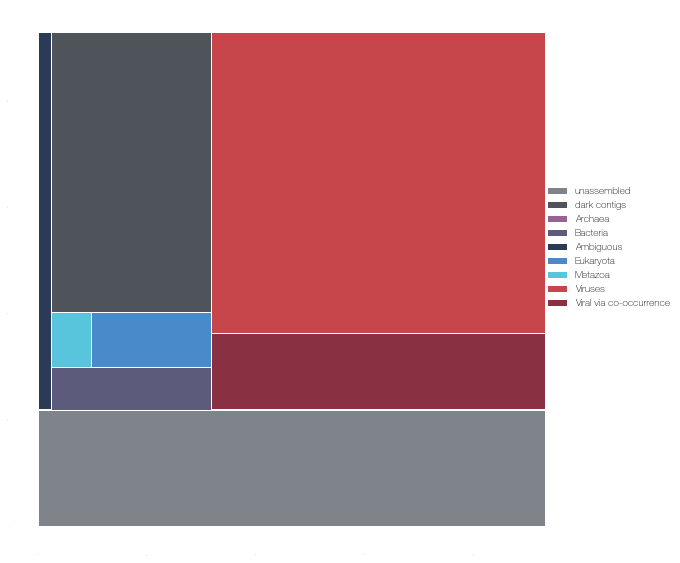

In [6]:
def computeCoordinates(node,x,y,dx,dy):
    """
    Compute treemap compartment coordinates using the squarify library.
    """
    node['x']=x ## assign coordinates to compartment
    node['y']=y
    node['dx']=dx
    node['dy']=dy
        
    if 'children' in node: ## there are children, need to traverse further
        children=sorted(node['children'],key=lambda q: size(q)) ## get children sorted by read count
        children_values=[size(child) for child in children] ## get read counts for each child
        children_values+=[size(node)-sum(children_values)]
        children_values=[s for s in children_values if s>0.0]
        sizes=squarify.normalize_sizes(children_values,dx,dy) ## normalize children values
        
        rects=squarify.padded_squarify(sizes,x,y,dx,dy) ## compute rectangles (padded)
#         rects=squarify.squarify(sizes,x,y,dx,dy) ## compute rectangles (unpadded)
        for ch,rec in zip(children,rects): ## iterate over children
            if size(ch)>0.0:
                x=rec['x']
                y=rec['y']
                dx=rec['dx']
                dy=rec['dy']

                computeCoordinates(ch,x,y,dx,dy) ## recurse

fmt=lambda y: r'$%.2f\times10^{%d}$'%(y*(10**-int(np.log10(y))),int(np.log10(y))) if y!=0.0 else '0.0'

effects=[path_effects.Stroke(linewidth=4, foreground='k'),
         path_effects.Stroke(linewidth=1, foreground='w')]

def plot(ax,node,zorder=0):
    """
    Plot treemap.
    """
    if 'x' in node:
        x=node['x']
        y=node['y']
        w=node['dx']
        h=node['dy']

    #     c='slategrey'
        c=node['colour']
        label=node['name'] if (('children' in node and (node['read_count']-sum([ch['read_count'] for ch in node['children']]))>1e3) or 'children' not in node) else ''
        rect=plt.Rectangle((x,y),w,h,facecolor=c,edgecolor='w',lw=1,alpha=1.0,label=label) ## rectangle for compartment
        
        ax.add_patch(rect) ## add rectangle

        if 'children' in node:
            for child in node['children']: ## iterate over children
                zorder+=1
                plot(ax,child,zorder=zorder) ## recursive call
            
fig = plt.figure(figsize=(10, 10),facecolor='w') ## new figure
gs = gridspec.GridSpec(1,1,wspace=0.01,hspace=0.01) ## using gridspec

ax=plt.subplot(gs[0],facecolor='w') ## new canvas

edge_length=np.sqrt(one_tree['read_count'])

computeCoordinates(one_tree,0.0,0.0,edge_length,edge_length) ## compute treemap compartment coordinates
plot(ax,one_tree) ## plot treemap

ax.legend(loc=(0.95,0.44),ncol=1,frameon=False)

ax.plot() ## null call to plot() to force matplotlib to plot patches

[ax.spines[loc].set_visible(False) for loc in ax.spines] ## remove spines
ax.tick_params(size=0,labelsize=0) ## remove ticks and tick labels

plt.show()

## Plot same information as bars

In [7]:
# reads,_=extract_nested_reads(one_tree)

# fig = plt.figure(figsize=(10,10),facecolor='w') ## new figure
# gs = gridspec.GridSpec(1,1,wspace=0.01,hspace=0.01) ## using gridspec

# ax=plt.subplot(gs[0],facecolor='w') ## new canvas

# xlabels=[]
# cmap=mpl.cm.tab10

# effects=[path_effects.Stroke(linewidth=4, foreground='k'),
#          path_effects.Stroke(linewidth=1, foreground='w')]

# for g,group in enumerate(reads):
#     G=reads[group]
#     children=sorted([ch for ch in G['children']] if 'children' in G else [],key=lambda k: -reads[k]['read_count'])
    
#     if len(children)>0:
#         Rs={ch:reads[ch]['read_count'] for ch in children}

#         if len(children)==1:
#             children.append(group)
#             Rs[group]=G['read_count']-sum(Rs.values())
        
# #         sorted_ch=sorted(Rs.keys(),key=lambda k: -Rs[k])
#         sorted_ch=sorted(Rs.keys(),key=lambda k: (k=='dark contigs',-Rs[k]))
#         Rs=[Rs[x] for x in sorted_ch]
#         for r,R in enumerate(Rs):
#             bottom=sum(Rs[:r])/sum(Rs)
#             height=R/sum(Rs)
            
#             if R>1e3:
#                 ax.text(len(xlabels),bottom+height/2,sorted_ch[r],size=10+height*10,ha='center',va='center',path_effects=effects,zorder=100)
#             fc=reads[sorted_ch[r]]['colour']
#             ax.bar(len(xlabels),height,bottom=bottom,facecolor=fc,edgecolor='w',width=0.9,lw=2,zorder=100)
        
#         xlabels.append(group)
        
# ax.set_xticks(range(len(xlabels)))
# ax.set_xticklabels(xlabels,rotation=0)

# ax.set_ylabel('fraction of reads',size=20)

# ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
# ax.tick_params(size=0,labelsize=20)

# ax.grid(axis='y',ls='--',zorder=0)
# [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['left']]

# ax.set_ylim(-0.001,1.001)
# plt.show()

## Plot per-sample information as treemap of treemaps

In [8]:
# def pad_rectangle(rect,p):
#     if rect["dx"] > p*2:
#         rect["x"] += p
#         rect["dx"] -= p*2
#     if rect["dy"] > p*2:
#         rect["y"] += p
#         rect["dy"] -= p*2


# def computeCoordinates(node,x,y,dx,dy,padding_func):
#     """
#     Compute treemap compartment coordinates using the squarify library.
#     """
#     node['x']=x ## assign coordinates to compartment
#     node['y']=y
#     node['dx']=dx
#     node['dy']=dy
        
#     if 'children' in node: ## there are children, need to traverse further
#         children=sorted(node['children'],key=lambda q: size(q)) ## get children sorted by read count
#         children_values=[size(child) for child in children] ## get read counts for each child
#         children_values+=[size(node)-sum(children_values)]
#         children_values=[s for s in children_values if s>0.0]
#         sizes=squarify.normalize_sizes(children_values,dx,dy) ## normalize children values
        
#         rects=squarify.padded_squarify(sizes,x,y,dx,dy) ## compute rectangles (padded)
#         for rect in rects:
#             padding_func(rect,4)
#         for ch,rec in zip(children,rects): ## iterate over children
#             if size(ch)>0.0:
#                 x=rec['x']
#                 y=rec['y']
#                 dx=rec['dx']
#                 dy=rec['dy']
                
#                 computeCoordinates(ch,x,y,dx,dy,padding_func) ## recurse

        
# def reset_coordinates(node):
#     if 'x' in node:
#         node.pop('x')
#         node.pop('dx')
#         node.pop('y')
#         node.pop('dy')
        
#         if 'children' in node:
#             for child in node['children']:
#                 reset_coordinates(child)

# for sample in grand_tree:
#     reset_coordinates(grand_tree[sample])
    
# super_tree={'name':'study','read_count':sum([grand_tree[s]['read_count'] for s in grand_tree]),'colour':'white','children':list(grand_tree.values())}

# fig = plt.figure(figsize=(20,20),facecolor='w') ## new figure

# gs = gridspec.GridSpec(1,1,wspace=0.01,hspace=0.01) ## using gridspec
# ax=plt.subplot(gs[0],facecolor='w') ## new canvas

# edge_length=np.sqrt(super_tree['read_count'])

# computeCoordinates(super_tree,0.0,0.0,edge_length,edge_length,pad_rectangle)

# plot(ax,super_tree)

# ax.plot()

# ax.set_xlim(0,edge_length)
# ax.set_ylim(0,edge_length)
# plt.show()
# # print()


## Plot per-sample information as individual bars on log scale

In [9]:
# species=lambda sample: '%s %s'%(metadata[sample]['ska_genus'],metadata[sample]['ska_species'])
# sample_loc=lambda sample: metadata[sample]['collected_by']


# fig = plt.figure(figsize=(30,50),facecolor='w') ## new figure

# sorted_samples=sorted(grand_tree,key=lambda k: grand_tree[k]['read_count'])#[:10]

# sample_reads=lambda k: sum([contig_classification[k][c]['read_count'] for c in contig_classification[k]]) if k in contig_classification else 0.0
# sorted_samples=list(filter(lambda k: 'water' not in k.lower() and sample_reads(k)>0,sorted_samples))

# ncols=11
# gs = gridspec.GridSpec(len(sorted_samples)//ncols+1,ncols,wspace=0.05,hspace=0.25) ## using gridspec
# # print(len(sorted_samples))
# store_ax=None

# order=['all reads','unassembled','contigs','Ambiguous','Bacteria','Archaea','Eukaryota','Metazoa','dark contigs','Viruses','Viral via co-occurrence']

# for i in range(len(sorted_samples)//ncols+1):
#     for j in range(ncols):
#         idx=i*ncols+j
#         if idx<len(sorted_samples):
#             sample=sorted_samples[idx]
#             flat_reads, _ = extract_nested_reads(grand_tree[sample])
            
#             if idx==0:
#                 ax=plt.subplot(gs[i,j],facecolor='w') ## new canvas
#                 store_ax=ax
#             else:
#                 ax=plt.subplot(gs[i,j],facecolor='w',sharey=store_ax) ## new canvas
            
#             for k in sorted(flat_reads,key=lambda k: flat_reads[k]['order']):
#                 x=order.index(k)
#                 reads=flat_reads[k]['read_count']+1
#                 colour=flat_reads[k]['colour']
                
#                 ax.bar(x,reads,facecolor=colour,edgecolor='none',zorder=100)
                
#             ax.set_yscale('log')
#             ax.grid(axis='y',zorder=0)
#             ax.set_ylim(1,8e5)
#             [ax.spines[loc].set_visible(False) for loc in ax.spines if loc in ['top','right']]
#             if j>0:
#                 ax.spines['left'].set_visible(False)
#                 ax.tick_params(axis='y',labelsize=0)
#                 for tline in ax.yaxis.get_minorticklines()+ax.yaxis.get_majorticklines():
#                     tline.set_visible(False)
#             ax.tick_params(axis='x',size=0,labelsize=0)
#             ax.set_xlabel('%s\n%s %s'%(sample,species(sample),sample_loc(sample)),size=10)

# plt.show()


## Plot per-sample information as limited number of bars

In [10]:
# sorted_samples=sorted(grand_tree,key=lambda k: -grand_tree[k]['read_count'])#[:10]

# sample_reads=lambda k: sum([contig_classification[k][c]['read_count'] for c in contig_classification[k]]) if k in contig_classification else 0.0
# sorted_samples=list(filter(lambda k: 'water' not in k.lower() and sample_reads(k)>0,sorted_samples))#[:15]

# read_areas=[grand_tree[sample]['read_count'] for sample in sorted_samples]

# species=lambda sample: '%s %s'%(metadata[sample]['ska_genus'],metadata[sample]['ska_species'])
# sample_loc=lambda sample: metadata[sample]['collected_by']


# ncols=11
# # ncols=5

# fig = plt.figure(figsize=(40,40),facecolor='w') ## new figure

# gs = gridspec.GridSpec(len(sorted_samples)//ncols+1,ncols,wspace=0.05,hspace=0.25) ## using gridspec
# print(len(sorted_samples))

# M=max(read_areas)

# contig_categories=['Ambiguous','Bacteria','Archaea','Eukaryota','Metazoa','dark contigs','Viruses','Viral via co-occurrence']

# for i in range(len(sorted_samples)//ncols+1):
#     for j in range(ncols):
#         idx=i*ncols+j
        
#         if idx<len(sorted_samples):
#             ax=plt.subplot(gs[i,j],facecolor='w') ## new canvas
            
#             sample=sorted_samples[idx]
#             sample_tree=grand_tree[sample]
#             sample_total=grand_tree[sample]['read_count']
            
#             xlabels=[]
#             reads,_=extract_nested_reads(sample_tree)
            
#             for g,group in enumerate(contig_categories):
#                 if 'children' in reads[group]:
#                     for ch in reads[group]['children']:
#                         reads[group]['read_count']-=reads[ch]['read_count']
                        
#             cy=reads['contigs']['read_count']/sample_total
#             uy=reads['unassembled']['read_count']/sample_total
            
#             w=0.9
#             ax.bar(0,sample_total/M,width=w,facecolor='k',edgecolor='k',zorder=100)
#             ax.bar(0,(1-sample_total/M),width=w,bottom=sample_total/M,facecolor='w',edgecolor='k',zorder=100)
            
#             ax.bar(1,cy,width=w,facecolor=reads['contigs']['colour'],zorder=100)
#             ax.bar(1,uy,width=w,bottom=cy,facecolor=reads['unassembled']['colour'],zorder=100)
            
#             contig_total=(sample_total-reads['unassembled']['read_count'])
            
#             for g,group in enumerate(contig_categories):
#                 y=reads[group]['read_count']/contig_total
#                 bottom=sum([reads[cc]['read_count'] for cc in contig_categories[:g]])/contig_total
#                 fc=reads[group]['colour']
#                 ax.bar(2,y,bottom=bottom,width=w,facecolor=fc,zorder=100)
            
            
#             ax.set_xlabel('%s\n%s %s'%(sample,species(sample),sample_loc(sample)),size=10)
#             ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
#             if j==0 or j==ncols-1:
#                 if j==ncols-1:
#                     ax.yaxis.set_label_position('right')
#                     ax.yaxis.tick_right()
                    
#                 ax.set_ylabel('fraction',size=14)
#                 ax.tick_params(axis='y',size=0,labelsize=12)
#             else:
#                 ax.tick_params(axis='y',size=0,labelsize=0)

#             ax.grid(axis='y',ls='--',zorder=0)
#             [ax.spines[loc].set_visible(False) for loc in ax.spines if loc not in ['left','right']]
#             ax.tick_params(axis='x',size=0,labelsize=0)
#             ax.set_ylim(-0.005,1.005)
            
# plt.show()